## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix ,accuracy_score,\
precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-07-07 17:58:42.167033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 17:58:42.167158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 17:58:42.281407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-df7fd474-52ac-41bd-84d4-4ead009187de)
GPU 1: Tesla T4 (UUID: GPU-4d94893b-3e4e-6665-2930-4b29c0ba5bac)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.8 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
print(f'{len(phishing_messages_1)} messages were extracted from file fradulent_emails.txt')

3976 messages were extracted from file fradulent_emails.txt


In [6]:
print('random message extracted from fradulent_emails.txt : \n','#'*100)
random.choice(phishing_messages_1)

random message extracted from fradulent_emails.txt : 
 ####################################################################################################


'Dear Partner,\n\nHow are doing today?\n\nI am Mr. NESTERUK ANDRIY a personal treasurer to Mikhail Khodorkovsky, owner of the following Companies: Chairman CEO: YUKOS OIL (Russian Largest Oil Company) Chairman CEO:Menatep SBP Bank (A well reputable financial institution with its Branches all Over the world).\n\nSOURCE OF FUNDS:\nI have a profiling amount in an excess of US$100.5M, which I seek your Partnership in accommodating for me. You will be rewarded \nwith 4% of the total sum for your  partnership. Can you be my partner on this? \n\nINTRODUCTION OF MY SELF:\nAs a personal consultant to him,authority was handed over to me in transfer of money of an American oil merchant for his last oil deal with my boss Mikhail Khodorkovsky. Already the funds have left the shores of America to a European private Bank where the final crediting is expected to be carried out. While I was on the process, My Boss got arrested for his Involvement in politics by financing the leading And opposing politi

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} from email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 from email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
print('a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :\n','#'*100)
print(f'{random.choice(ham_messages)}')

a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :
 ####################################################################################################
URL: http://www.aaronsw.com/weblog/000644
Date: 2002-10-08T01:21:33-06:00

DeCSS detractors have repeatedly claimed that DeCSS needs to be stopped because 
it makes perfect digital copies of DVDs possible. Recently, in private email, 
Ernest Miller claimed that doing so would be a violation of the DMCA. In this 
in-depth special report, I show that using perfectly legal, (I assume) 
licensed, off-the-shelf consumer software, copying DVDs is easy and in many 
ways encouraged. 

*Tools:*
1 PowerBook G4 with slot-loading DVD drive (any model should work)
1 Monsters, Inc. Collector's Edition DVD (any DVD should work)
1 copy of Mac OS X 10.2 "Jaguar" 

*Process:*
1. Insert DVD into drive. Notice how Jaguar helpfully loads the DVD Player for 
you.
2. Open the DVD (it appears on the desktop) a

In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
print('a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:\n','#'*100)
print(f'{random.choice(phishing_messages_2)}') 

a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:
 ####################################################################################################
*****************BANNEDCD::::::::::::::::::::::::::::::::::>NET******************

I have been receiving emails saying that I'm contributing to the "moral decay of society" by selling the Banned CD.  That may be, but I feel strongly that you have a right to benefit from 
this hard-to-find information. 

So I am giving you ONE LAST CHANCE to order the Banned CD! 

With this powerful CD, you will be able to investigate your friends, enemies and lovers in just minutes using the Internet.  You can track down old flames from college, or you can dig up some dirt on your boss to make sure you get that next promotion! 
  

Or maybe you want a fake diploma to hang on your bedroom wall.  You'll find addresses for companies that make these diplomas on the Banned CD. 

Need to disappear fast and 

In [11]:
## getting meassages from html like messages using beatiful soup 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
print('a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:\n','#'*100)
print(f'{random.choice(phishing_messages_3)}')

a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:
 ####################################################################################################
Do you like Sexy Animals doing the wild thing? We have the super hot content on the Internet!

This is the site you have heard about. Rated the number one adult site three years in a row!

- Thousands of pics from hardcore fucking, and cum shots to pet on girl.



- Thousands videos



So what are you waiting for?




CLICK HERE






YOU MUST BE AT LEAST 18 TO ENTER!


 


 


 


You have received this advertisement because you have opted in 
to receive 

free adult internet offers and 



specials through our affiliated websites. If you do not wish to receive 

further emails or have received the 



email in error you may opt-out of our database by clicking here: 


CLICK HERE

Please allow 24hours for removal.

This e-mail is sent in compliance with the Infor

In [13]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total benign messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)} message')



Total benign messages extracted from  emails-enron-legal-mails.mbox : 4279 message


In [14]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:\n','-'*100)
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:
 ----------------------------------------------------------------------------------------------------
--

 


 ####################################################################################################
Vince,

Please find attached a small note I had prepared at Wade's request.  The note 
is to be used for a private meeting of the ex-Chairman of MSEB with the 
governor of Maharashtra.  In the Indian system, the Governor represents the 
Federal government in the state.  Hence any information he gathers is for the 
Central Govt.

This informal note is to be passed to him.  The focus as you will see is to 
see if we can engage the Central govt. through this route.

Krishna is here and sends his regards.

Regards,
Sandeep.
---------------------- Forwarded by Sandeep Kohli/ENRON_DEVELOPMENT on 
01/16/2001 08:55 AM ---------------------------


Sandeep Kohli
01/16/2001 08:51 AM
To: Wade Cline/ENRON_DEVE

In [15]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# creating a list of cleaned messages 
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [16]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :\n','-'*100)

for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :
 ----------------------------------------------------------------------------------------------------
Hello!

Please click on the proceeding link to view Chef Mark Cox's newsletter!  

http://www.my3dm.com/marks.htm
This page is best displayed at 800 X 600.



To be removed from Mark*s American Cuisine's mailing list please click the following email address and type in "remove".  Please note that your email address is held in strict confidence of Mark*s American Cuisine and will not be sold or given away.  We appreciate your business and look forward to serving you soon!

markscuisine@hotmail.com 

 ####################################################################################################
Forwarded as we discussed.  Likewise, I will check with Gary regarding the 
status.


	Dan J Hyvl
	02/02/2001 08:37 AM
		
		 To: Gary W Lamphier/HOU/ECT@ECT
		 cc: 
		 Subject: Re: Westhollow Tec

### Getting phishing emails from  emails-phishing-nazario.mbox

In [17]:

# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: {len(phishing_nazario_messages)} message")




Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: 2279 message


In [18]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that cause Unicodeerror')


removed 141 messages that cause Unicodeerror


In [19]:
print(f'{len(cleaned_phishing_nazario_messages)} phishing messages remains after removing message that cause Unicodeerror' )

2138 phishing messages remains after removing message that cause Unicodeerror


In [20]:
# let's have a look on sample of cleaned_phishing_nazario_messages
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after removing message that cause Unicodeerror :\n','-'*100)

for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after removing message that cause Unicodeerror :
 ----------------------------------------------------------------------------------------------------
Return-Path: <anonymous@merkur.domains.sk>
X-Original-To: user@login.example.com
Delivered-To: user@login.example.com
Received: from mail.example.org (mail.example.org [192.168.4.9])
	by example.com (Postfix) with ESMTP id C391E469DF
	for <user@login.example.com>; Sun,  1 Oct 2006 13:42:18 -0400 (EDT)
Received: from merkur.domains.sk (merkur.domains.sk [82.208.46.130])
	by mail.example.org (Postfix) with SMTP id 7B6E66CCF34
	for <user@example.com>; Sun,  1 Oct 2006 13:42:18 -0400 (EDT)
Received: (qmail 29335 invoked by uid 81); 1 Oct 2006 19:42:13 +0200
Date: 1 Oct 2006 19:42:13 +0200
Message-ID: <20061001174213.29331.qmail@merkur.domains.sk>
To: user@example.com
X-MailerWWW: www.rhodesianridgeback.sk 15 15 0 4902
Subject: Securit

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [21]:
# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)



In [22]:
# let's have a look on sample of cleaned_phishing_nazario_messages_text 
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after extracting messages from html format and cleaning message body :\n','='*100)

for m in random.sample(cleaned_phishing_nazario_messages_text,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after extracting messages from html format and cleaning message body :






  









 Dear  
nbsd-mobile-outgoing@example.com,
 
 


It has come to our attention that 
your 
PayPal
=AE
 =

account information needs to 
be 
updated as part of our continuing commitment to protect your 
account and to 
reduce the 
instance of fraud on our website. 
 If you could 
please take 5-10 minutes 
out of your 
online 
experience and update your personal records you will not run 
into 
any future 
problems with the online 
service. 
         &n=
bsp;           &nbs=
p;            =
 


However, failure to update your records w=
ill 
result in account 
suspension. 
Please update your records on or 
before 
October 04, 2006
.
&nb=
sp;
Once you have updated your account 
records, your 
PayPal
=AE
 session will not 
be 
interrupted and will continue as normal. 


To update your 
PayPal
=AE
 

In [23]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages


cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)



In [24]:
# to find if the long text was removed or not 
cleaned_phishing_nazario_messages_text_1[:5]

['in 1841 stars battle Tour de France in 1872 in 1923',
 'Dear eBay User , After fraud complaints from the eBay members, the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take 5 days, period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement, eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. Regards,Safeharbor Department eBay, Inc.',
 "Dea

## Getting all data into a dataframe 

In [25]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [26]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_3+cleaned_phishing_nazario_messages_text_1
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,"Dear PayPal Member, Your account has been rand..."
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,"Dear eBay user, eBay Customer Support Team req..."
8383,1,"Dear PayPal Member, Your account has been rand..."


In [27]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [28]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,"Dear eBay member, Congratulations! Your recent..."
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email \nBlaster\n \n\n\nThe program wil...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [29]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [30]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [31]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4594

In [32]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1913 duplicated phishing messages in data 


In [33]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [34]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [35]:
# counting classes in data after remvoing duplicates 

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6472 phishing messages and 8545 ham messages in data after removing Duplicates


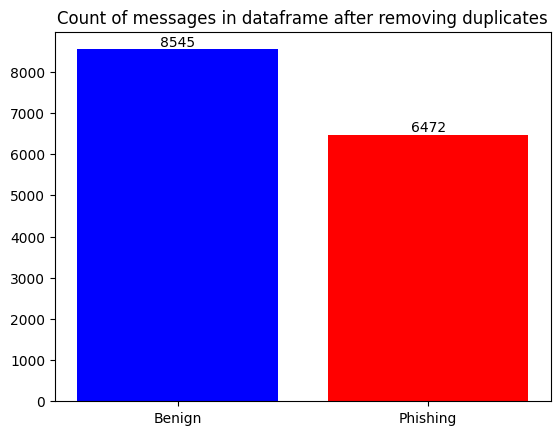

In [36]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [37]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [38]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,"Dear eBay member, Congratulations! Your recent..."
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?\n\n\nIf you do you w...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [39]:
# splitting data into 80% train and 20% test data 
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [40]:
# counting classes in train data to check for balance 
train_labels.value_counts()

phishing
0    6783
1    5230
Name: count, dtype: int64

In [41]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 12013 message


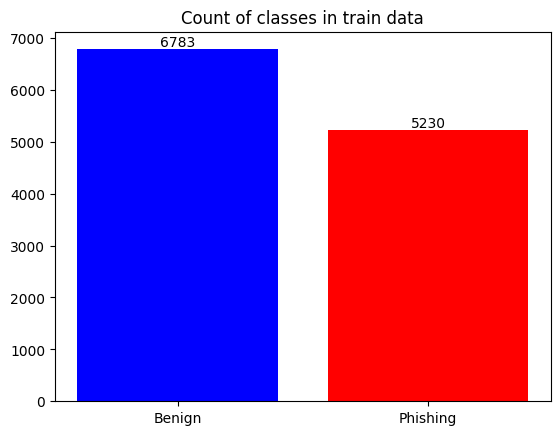

In [42]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [43]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 3004 message


In [44]:
# counting classes in test data to check for balance 

print(test_labels.value_counts())


phishing
0    1762
1    1242
Name: count, dtype: int64


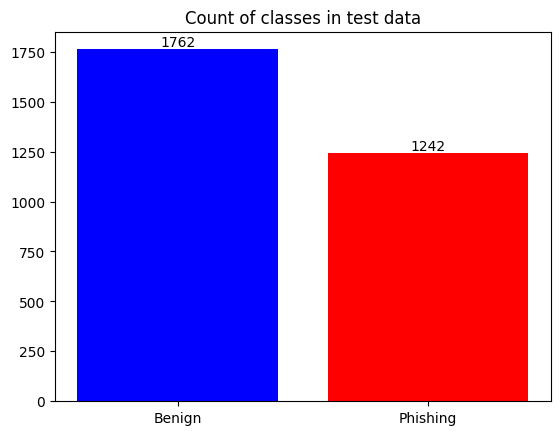

In [45]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [46]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [47]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[1920,
 3,
 228,
 1785,
 193,
 109,
 513,
 37,
 141,
 40,
 133,
 1361,
 45,
 233,
 168,
 552,
 211,
 123,
 385,
 118,
 2,
 104,
 1251,
 212,
 106]

In [48]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1080 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [49]:
## making Text vectorization layer 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024)

In [50]:
# adapting text vectorizer on train data 
text_vectorizer.adapt(train_text)

In [51]:
# getting a list of words in the train data 
words_in_vocab=text_vectorizer.get_vocabulary()

In [52]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [53]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['finalizing',
 'fighters',
 'fifteenmillion',
 'fibroid',
 'ff',
 'fetching',
 'ferrostall',
 'fernandez',
 'fel',
 'feast',
 'fcalgerenroncom',
 'façon',
 'favouring',
 'faulty',
 'fatigue',
 'fastow',
 'fastcheck',
 'fantasia',
 'famers',
 'faites']

In [54]:
# testing text vectorizer for a sentence 
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1133, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [55]:
# creating an embedding layer with sequence length 1024  words and  sees most common 200000 words 
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [56]:
# testing embedding layer for a sentence 
embed(text_vectorizer([sentence]))

<tf.Tensor: shape=(1, 1024, 128), dtype=float32, numpy=
array([[[-0.03261969,  0.03425324,  0.0219594 , ..., -0.0389968 ,
         -0.01108129,  0.00303297],
        [ 0.03309569,  0.00419511, -0.02656689, ..., -0.03884151,
         -0.00940442, -0.04864781],
        [ 0.03649649, -0.04841296, -0.03573966, ...,  0.00343851,
         -0.03401989, -0.03443019],
        ...,
        [-0.01021772,  0.02890313, -0.03839445, ..., -0.02383167,
         -0.01166506, -0.04946975],
        [-0.01021772,  0.02890313, -0.03839445, ..., -0.02383167,
         -0.01166506, -0.04946975],
        [-0.01021772,  0.02890313, -0.03839445, ..., -0.02383167,
         -0.01166506, -0.04946975]]], dtype=float32)>

## Satrting Experiments 

In [57]:
## creating functions for callbacks 

# function to create a checkpoint callback 
def create_checkpoint_callback(file_path):
    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=False,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return cnn_model_checkpoint_callback
# function to create a tensorboard callback 
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

## Long-Term Short Memory (LSTM) model  

In [58]:
import tensorflow as tf 
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

#### creating tensorboard , early stopping and checkpoint callpacks 

In [59]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [75]:
# training lstm_model_1 
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.7844 - loss: 0.4082 - val_accuracy: 0.9702 - val_loss: 0.1128
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9710 - loss: 0.0975 - val_accuracy: 0.9572 - val_loss: 0.2088
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9724 - loss: 0.1033 - val_accuracy: 0.9017 - val_loss: 0.2427
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9763 - loss: 0.0685 - val_accuracy: 0.9768 - val_loss: 0.0855
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9643 - loss: 0.1092 - val_accuracy: 0.9813 - val_loss: 0.0720
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9920 - loss: 0.0336 - val_accuracy: 0.9816 - val_loss: 0.0690
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9952 - loss: 0.0182 - val_accuracy: 0.9721 - val_loss: 0.1074
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9920 - loss: 0.0283 - 

In [76]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [77]:
# craeting function to plot training curves 
def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


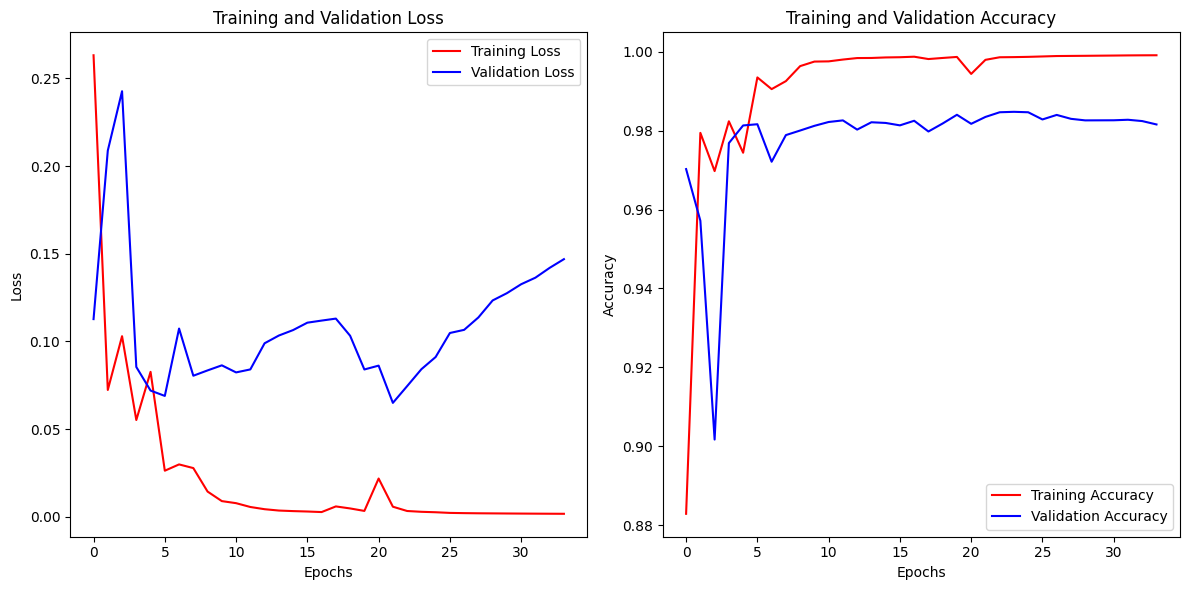

In [78]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [79]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


(3004, 1024, 1)

In [80]:
import seaborn as sns
# creating function to plot confusion matrix 
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [81]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to calculate other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [82]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

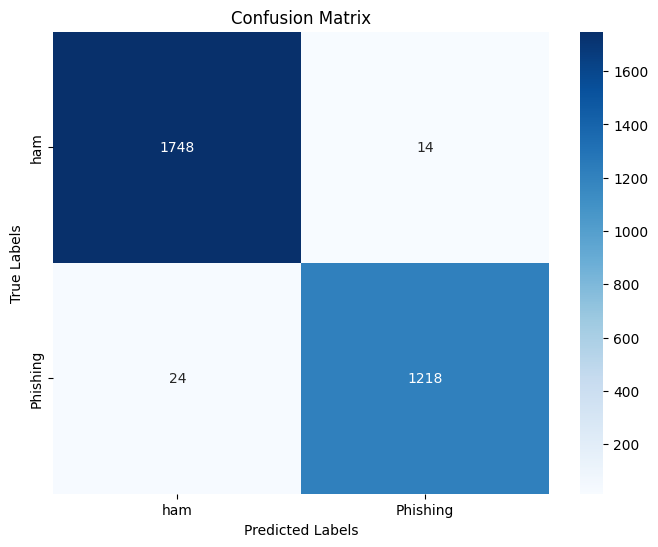

In [83]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [84]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.9873501997336884 

precision 0.9873574579949902 

recall 0.9873501997336884 

f1 0.9873425315360559 



In [85]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels.values,avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1762
           1       0.99      0.98      0.98      1242

    accuracy                           0.99      3004
   macro avg       0.99      0.99      0.99      3004
weighted avg       0.99      0.99      0.99      3004



In [86]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels.values,avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.011363636363636364 

False Negative Rate (FNR) 0.01932367149758454 

False Omission Rate (FOR) 0.013544018058690745 

False Positive Rate (FPR) 0.007945516458569807 

Negative Prediction Value (NPV) 0.9864559819413092 



### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [87]:
# to get a list of layers in lstm_model_1 
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [88]:
# storing weights of embedding layer in variable embedding_weights 
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[-0.31029704 -0.6967634   0.36283913 ...  0.39734754 -1.5162266
   1.6709152 ]
 [-0.00725156  0.00439696  0.0251863  ...  0.07196081  0.00169653
   0.18418805]
 [ 0.0693128  -0.05412813  0.00696297 ...  0.05955704  0.08134766
   0.11214127]
 ...
 [-0.00648279  0.01203781 -0.05120412 ...  0.03744235  0.05375237
   0.0208781 ]
 [-0.01057468  0.00318808 -0.03078764 ... -0.00613663  0.01283353
  -0.02713145]
 [ 0.07662929 -0.06188612  0.05948206 ...  0.07310058 -0.00340867
   0.00541488]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [89]:
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [90]:
# Create 1-dimensional convolutional layer to model sequences
from keras import regularizers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embed(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
cnn_model.summary()


Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,689 (9.85 MB)

 Trainable params: 2,582,689 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [92]:
# fitting cnn model 
cnn_history=cnn_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7348 - loss: 0.7821 - val_accuracy: 0.9700 - val_loss: 0.1208
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9707 - loss: 0.1194 - val_accuracy: 0.9754 - val_loss: 0.0933
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9921 - loss: 0.0668 - val_accuracy: 0.9794 - val_loss: 0.0796
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9948 - loss: 0.0511 - val_accuracy: 0.9807 - val_loss: 0.0787
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9967 - loss: 0.0436 - val_accuracy: 0.9797 - val_loss: 0.0756
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9973 - loss: 0.0391 - val_accuracy: 0.9814 - val_loss: 0.0723
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9978 - loss: 0.0350 - val_accuracy: 0.9817 - val_loss: 0.0667
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0304 - val_accu

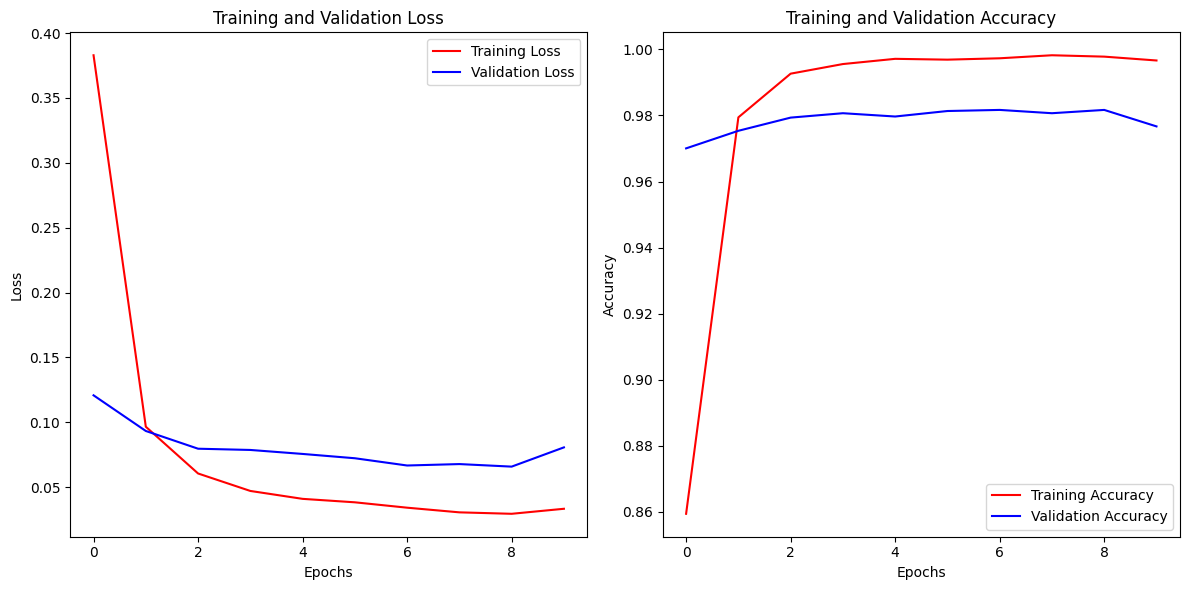

In [93]:
# plotting training curves for cnn model 



plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [94]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


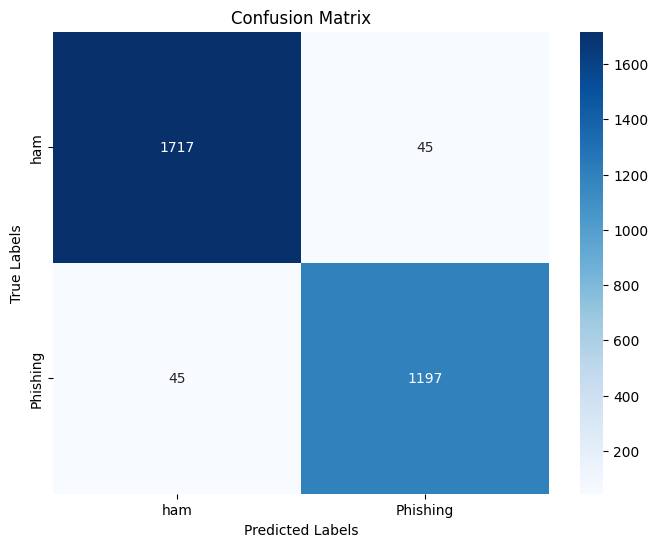

In [95]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [96]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9700399467376831, 'precision': 0.9700399467376831, 'recall': 0.9700399467376831, 'f1': 0.9700399467376831}


In [97]:
# classification report of  cnn_model  
report_2=classification_report(test_labels.values,avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1762
           1       0.96      0.96      0.96      1242

    accuracy                           0.97      3004
   macro avg       0.97      0.97      0.97      3004
weighted avg       0.97      0.97      0.97      3004



In [98]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.036231884057971016 

False Negative Rate (FNR) 0.036231884057971016 

False Omission Rate (FOR) 0.02553916004540295 

False Positive Rate (FPR) 0.02553916004540295 

Negative Prediction Value (NPV) 0.9744608399545971 



## GRU model 

In [99]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 

x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell

outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [101]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7114 - loss: 0.5129 - val_accuracy: 0.9704 - val_loss: 0.0898
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9781 - loss: 0.0725 - val_accuracy: 0.9784 - val_loss: 0.0761
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9901 - loss: 0.0301 - val_accuracy: 0.9815 - val_loss: 0.0573
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9833 - val_loss: 0.0673
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9836 - val_loss: 0.0816
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9844 - val_loss: 0.0974
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9845 - val_loss: 0.0870
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9989 - loss: 0.0027 - 

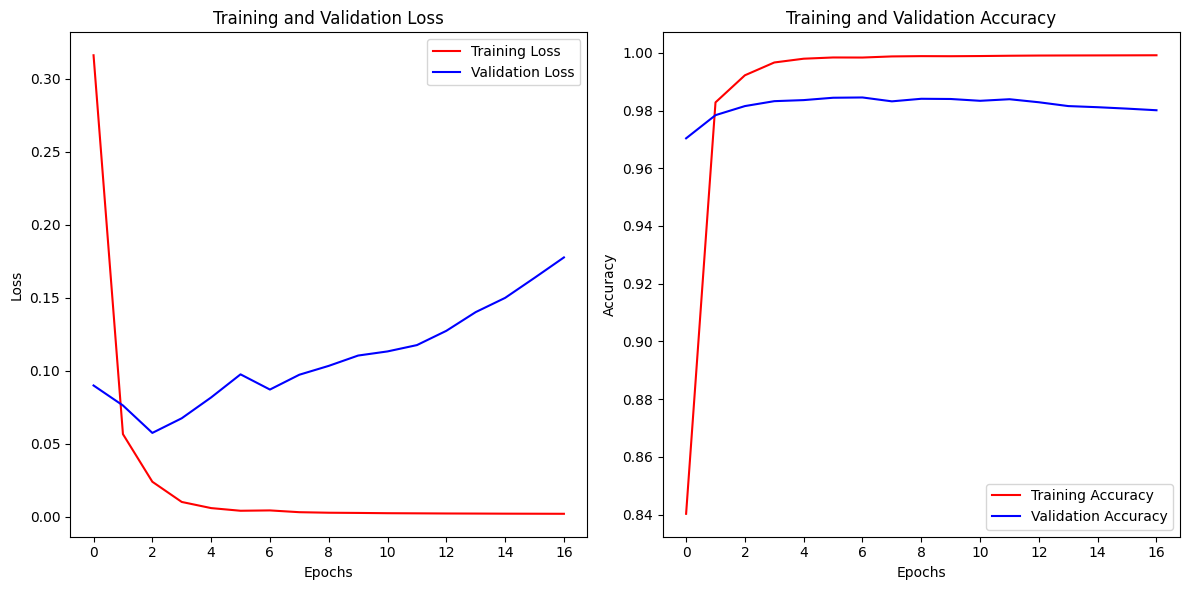

In [102]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [103]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


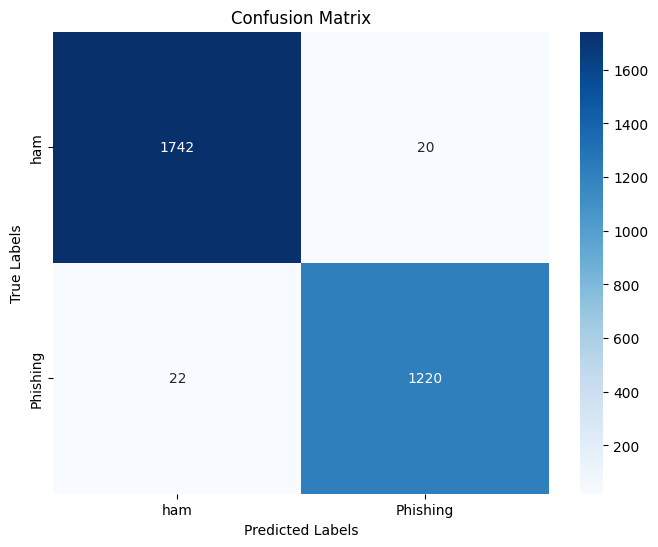

In [104]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [105]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.9860186418109188 

precision 0.9860228779146082 

recall 0.9860186418109188 

f1 0.9860203096946618 



In [106]:
# classification report of gru_model 
report_3=classification_report(test_labels.values,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1762
           1       0.98      0.98      0.98      1242

    accuracy                           0.99      3004
   macro avg       0.99      0.99      0.99      3004
weighted avg       0.99      0.99      0.99      3004



In [107]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.016129032258064516 

False Negative Rate (FNR) 0.017713365539452495 

False Omission Rate (FOR) 0.012471655328798186 

False Positive Rate (FPR) 0.011350737797956867 

Negative Prediction Value (NPV) 0.9875283446712018 



In [134]:
def predict_message_sentiment(model, message):
    # Ensure the input message is in the correct format
    message = tf.convert_to_tensor([message])
    
    # Predict using the model
    prediction = model.predict(message)
    
    return prediction

# Example usage:
phishing_message = """Our records indicate that your payment method for your streaming service subscription has expired. To avoid interruption of your service, please update your payment information immediately. Click here to update your payment details: [deceptive link] Your account overview: Username: [email address] Subscription: Premium Plan Next billing date: [tomorrow's date] If you do not update your payment method within 24 hours, your account will be downgraded to the free plan with limited access.
"""
prediction = predict_message_sentiment(gru_model, phishing_message)
avg_prediction=np.mean(prediction, axis=1)
avg_prediction=np.round(avg_prediction.flatten())
print('predicted: phishing message' if avg_prediction[0]==1 else 'predicted: benign message')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted: phishing message


## Bidirectonal LSTM model 

In [109]:
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [110]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# training bidirectonal_model
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.8555 - loss: 0.2942 - val_accuracy: 0.9707 - val_loss: 0.0783
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9753 - loss: 0.0671 - val_accuracy: 0.9787 - val_loss: 0.0660
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.9780 - val_loss: 0.0709
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accuracy: 0.9750 - val_loss: 0.0805
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.9387 - val_loss: 0.1721
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9882 - loss: 0.0308 - val_accuracy: 0.9744 - val_loss: 0.0904
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9968 - loss: 0.0087 - val_accuracy: 0.9710 - val_loss: 0.0974
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9992 - loss: 0.0029 - 

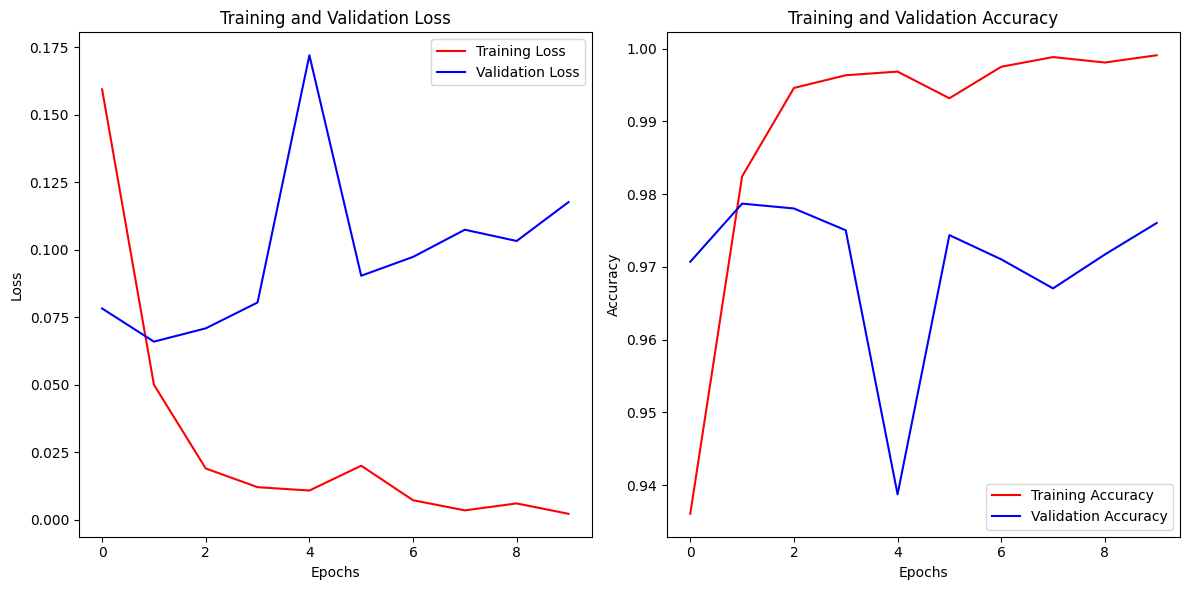

In [112]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [113]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


In [114]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9707057256990679 

precision 0.9708283135017844 

recall 0.9707057256990679 

f1 0.9706536580855761 



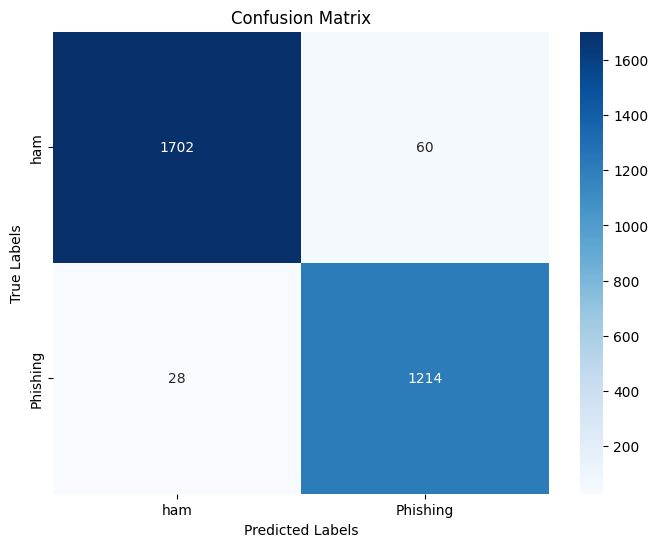

In [115]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

In [116]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels.values,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1762
           1       0.95      0.98      0.97      1242

    accuracy                           0.97      3004
   macro avg       0.97      0.97      0.97      3004
weighted avg       0.97      0.97      0.97      3004



In [117]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.04709576138147567 

False Negative Rate (FNR) 0.02254428341384863 

False Omission Rate (FOR) 0.016184971098265895 

False Positive Rate (FPR) 0.0340522133938706 

Negative Prediction Value (NPV) 0.9838150289017341 



## A simple dense model

In [118]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,129 (9.77 MB)

 Trainable params: 2,560,129 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# creating custom early stopping callback for dense model with higher patience 
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [120]:
# trainging dense model 
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6842 - loss: 0.5852 - val_accuracy: 0.8675 - val_loss: 0.3220
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8946 - loss: 0.2940 - val_accuracy: 0.9101 - val_loss: 0.2110
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9218 - loss: 0.2121 - val_accuracy: 0.9301 - val_loss: 0.1733
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9350 - loss: 0.1786 - val_accuracy: 0.9431 - val_loss: 0.1517
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9423 - loss: 0.1582 - val_accuracy: 0.9537 - val_loss: 0.1374
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9484 - loss: 0.1436 - val_accuracy: 0.9624 - val_loss: 0.1276
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9526 - loss: 0.1321 - val_accuracy: 0.9650 - val_loss: 0.1207
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9554 - loss: 0.1224 - val_accu

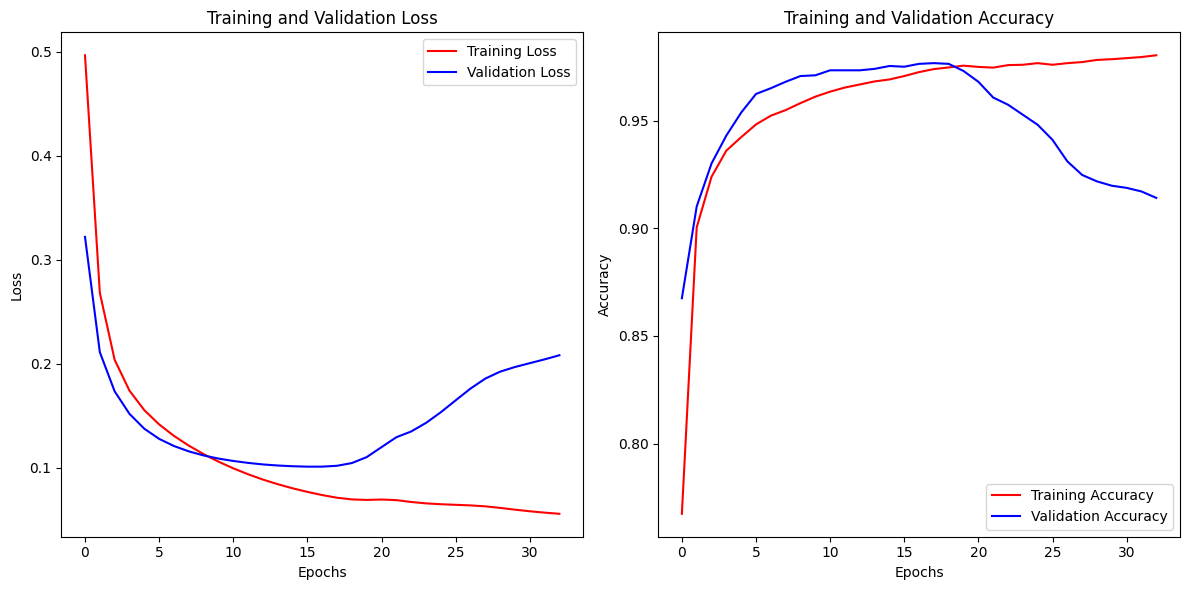

In [121]:
# plotting training curves for Dense model 


plot_loss_and_accuracy_curves(dense_model_history)

### Evaluating Dense model

In [122]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [123]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.9766977363515313 

precision 0.9767993444278459 

recall 0.9766977363515313 

f1 0.9766611827488674 



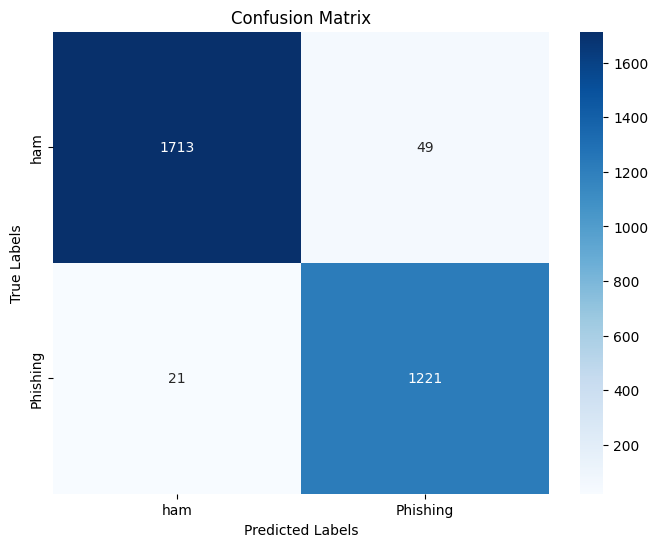

In [124]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels.values)

In [125]:
# classification report of dense_model 
report_5=classification_report(test_labels.values,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1762
           1       0.95      0.98      0.97      1242

    accuracy                           0.97      3004
   macro avg       0.97      0.97      0.97      3004
weighted avg       0.97      0.97      0.97      3004



In [126]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.03858267716535433 

False Negative Rate (FNR) 0.016908212560386472 

False Omission Rate (FOR) 0.012110726643598616 

False Positive Rate (FPR) 0.027809307604994324 

Negative Prediction Value (NPV) 0.9878892733564014 



### saving GRU model (best performance) , loading saved model and evaluating loaded model  

In [127]:
# saving gru_model to be able to use it later 
def save_model(model): 
    model.save('GRU_model.h5')
save_model(gru_model)    

In [128]:
gru_model.layers

[<InputLayer name=input_layer_3, built=True>,
 <TextVectorization name=text_vectorization_3, built=True>,
 <Embedding name=embedding_3, built=True>,
 <GRU name=gru_1, built=True>,
 <Dense name=dense_6, built=True>,
 <Dense name=dense_7, built=True>]

In [129]:
# loading saved model 
from keras import layers 
loaded_gru_model=tf.keras.models.load_model('GRU_model.h5')

In [130]:
text_vectorizer.adapt(train_text) 

In [131]:
# Save the TextVectorization vocabulary
vocab = text_vectorizer.get_vocabulary()
with open('vocab.txt', 'w') as f:
    for word in vocab:
        f.write(f"{word}\n")



In [132]:
# vocab

In [133]:
from keras.layers import TextVectorization

def load_vocab(filepath):
    with open(filepath, 'r') as f:
        vocab = [line.strip() for line in f.readlines()]
    # Remove duplicates by converting to a set and back to a list
    vocab = list(set(vocab))
    # Ensure reserved tokens are correctly handled
    reserved_tokens = ['', '[UNK]']
    vocab = [token for token in vocab if token not in reserved_tokens]
    vocab = reserved_tokens + vocab  # Ensure reserved tokens are at the start
    return vocab

def predict_message_sentiment(model, message):
    # Ensure message is in the correct format as a 1-dimensional array of strings
    message = np.array([message])  # Convert to NumPy array and shape correctly
    message = tf.convert_to_tensor(message, dtype=tf.string)

   

    # Predict using the model
    prediction = model.predict(message)
    
    return prediction

# Example phishing message
phishing_message = '''Dear alex bank Customer,

Your account is at risk! We have detected unauthorized access attempts on your account. Please log in immediately to verify your account details and secure your account.

Click here to log in: b

If you did not request this action, please contact our support team immediately.

Thank you for your prompt attention to this matter.

Sincerely,
[Your Bank] Security Team
'''

benign_message='''Hi john,

I hope this message finds you well. I wanted to follow up on our discussion from yesterday's meeting. Could you please send me the latest report when you have a moment?

Thanks,
mark johanson
'''
# Load the model
loaded_gru_model = tf.keras.models.load_model('GRU_model.h5')

# Load and reinitialize the TextVectorization layer
vocab = load_vocab('vocab.txt')
text_vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=1024)
text_vectorizer.set_vocabulary(vocab)

# Replace the existing TextVectorization layer in the model
loaded_gru_model.get_layer('text_vectorization').set_vocabulary(vocab)

# Predict sentiment for the phishing message
prediction = predict_message_sentiment(loaded_gru_model, benign_message)
avg_prediction = np.mean(prediction, axis=1)
avg_prediction = np.round(avg_prediction.flatten())

print('predicted: benign message' if avg_prediction[0]==0 else 'predicted: phishing message')


ValueError: No such layer: text_vectorization. Existing layers are: ['input_layer_3', 'text_vectorization_3', 'embedding_3', 'gru_1', 'dense_6', 'dense_7'].

In [ ]:
# predicting test_labels for loaded_gru_model 
pred_labels_gru_loaded=loaded_gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru_loaded = np.mean(pred_labels_gru_loaded, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru_loaded=np.round(avg_pred_labels_gru_loaded.flatten())

In [ ]:
# plotting confusion metrix for loaded_gru_model
plot_confusion_matrix(y_pred=avg_pred_labels_gru_loaded,y_true=test_labels.values)

In [ ]:
# evaluating loaded GRU model 
print('Metrics for loaded GRU model\n')

for key,value in calculate_results(avg_pred_labels_gru_loaded,test_labels.values).items(): 
    print(key,value,'\n')

In [ ]:
# classification report of loaded_gru_model 
report_5=classification_report(test_labels.values,avg_pred_labels_gru_loaded)
print(f"classification report for loaded_gru_model \n\n {report_5}")

In [ ]:
# calculating other metrices for loaded_gru_model
print('Other metrics for loaded_gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru_loaded).items():
    
    print(key,value,'\n')

### Creating tensorboard for experiments 
>##### to visualize tensorboard download logs.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 



In [ ]:
## zipping logs directory to download it and visualize tensorboards on local pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs

In [ ]:
# zipping checkpoints directory to be able to download it 
!zip -r /kaggle/working/checkpoints.zip /kaggle/working/checkpoints

## Comparing models results 

In [ ]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

In [ ]:
# making a dictionary of other metrics for each model 
cnn_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_dense_model)

other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

In [ ]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

In [ ]:
# making a function that plots a bar plot for comparion of metrics between columns 
def plot_bar_plot_of_metric(column_name : str , color : str):
    """
    Plots a bar chart of a specified metric from a DataFrame, sorted in descending order.

    Parameters:
    - column_name (str): The name of the column/metric to plot.
    - color (str): The color code for the bars in the plot (e.g., 'FF5733' for orange).

    Returns:
    - None: Displays the plot directly using matplotlib.

    Example Usage:
    >>> plot_bar_plot_of_metric('False Positive Rate (FPR)', 'FF5733')
    """

    

    ax = all_metrics_df.sort_values(column_name, ascending=False)[column_name].plot(kind='bar', figsize=(9, 8), color=f'#{color}')

    # Adding value labels above each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Adding title and labels
    plt.title(f'Models Sorted Descendingly by {column_name}')
    plt.ylabel(f'{column_name}%', fontsize=12)

    # Adding grid and rotating x-axis labels
    plt.grid()
    plt.xticks(rotation=0)

    # Displaying the plot
    plt.show()

In [ ]:
# plotting bar plot for models sorted descendingly by accuracy

plot_bar_plot_of_metric('accuracy','6F4E37')

In [ ]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

In [ ]:
# plotting bar plot for models sorted descendingly by precision
plot_bar_plot_of_metric('precision','102C57')

In [ ]:
# plotting bar plot for models sorted descendingly by recall 
plot_bar_plot_of_metric('recall','365E32')

In [ ]:
# Plotting bar plot for models sorted descendingly by NPV
plot_bar_plot_of_metric('Negative Prediction Value (NPV)','FF7F3E')

In [ ]:
# Plotting bar plot for models sorted descendingly by FNR

plot_bar_plot_of_metric('False Negative Rate (FNR)','1679AB')

In [ ]:
# Plotting bar plot for models sorted descendingly by FPR

plot_bar_plot_of_metric('False Positive Rate (FPR)','6F4E37')

In [ ]:
# Plotting bar plot for models sorted descendingly by FDR

plot_bar_plot_of_metric('False Discovery Rate (FDR)','006769')

In [ ]:
# Plotting bar plot for models sorted descendingly by FOR

plot_bar_plot_of_metric('False Omission Rate (FOR)','DD761C')

In [ ]:
# Plotting bar plot for models sorted descendingly by F1 score 

plot_bar_plot_of_metric('f1','7469B6')

## Comparing prediction time for models 

In [ ]:
# taking a sample of messages 
messages_sample=test_text.sample(30)


In [ ]:
# creating a function to caculate average prediction time for a model 
import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [ ]:
calculate_pred_time(lstm_model_1,messages_sample)


In [ ]:
calculate_pred_time(gru_model,messages_sample)


In [ ]:
calculate_pred_time(cnn_model,messages_sample)


In [ ]:
calculate_pred_time(bidirectonal_model,messages_sample)


In [ ]:
calculate_pred_time(dense_model,messages_sample)


## Finding wrong predictions with heighest prediction probablities 

In [ ]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

In [ ]:
# shape of predicted lables 
predicted_labels_gru_model.shape

In [ ]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

In [ ]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [ ]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

In [ ]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

In [ ]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

In [ ]:
test_text

In [ ]:
test_labels

In [ ]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

In [ ]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

In [ ]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [ ]:
test_predictions_df

In [ ]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [ ]:
# how many messages their predicted_labels are  wrong of test_text
print(f'there are {len(mistake_df)} mestakes in precdiction for this model')

In [ ]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

In [ ]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

In [ ]:
# how many false_positives
print(f'there are {len(false_positives)} false positive messages')

In [ ]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

### Testing  False Positives 

In [ ]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

In [ ]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [ ]:
false_negatives 

In [ ]:
# how many false_negatives

len(false_negatives)

In [ ]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

In [ ]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

In [ ]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 